In [292]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt

In [293]:
sc_econ_df = pd.read_csv('processed_individual/sc_econ_block.csv')
sc_election_df = pd.read_csv('processed_individual/sc_election_block.csv')
sc_race_df = pd.read_csv('processed_individual/sc_race_block.csv')

In [294]:
print(sc_econ_df.columns)
print(len(sc_econ_df))

Index(['GEOID', 'STATEFP', 'STATE', 'COUNTYFP', 'COUNTY', 'MEDN_INC22',
       'TOT_HOUS22', 'LESS_25K', '25K_45K', '45K_75K', '75K_125K', '125K_200K',
       '200K_MORE'],
      dtype='object')
3408


In [295]:
print(sc_election_df.columns)
print(len(sc_election_df))

Index(['GEOID', 'TOT_VOTER', 'DEM_VOTER', 'REP_VOTER', 'OTHPAR_VOTER',
       'WHITE_VOTER', 'BLACK_VOTER', 'EASIAN_VOTER', 'HISP_VOTER',
       'NATIVE_VOTER', 'OTHRACE_VOTER'],
      dtype='object')
146844


In [296]:
print(sc_race_df.columns)
print(len(sc_race_df))

Index(['GEOID', 'STATEFP', 'STATE', 'COUNTYFP', 'COUNTY', 'TOT_POP22',
       'NHSP_POP22', 'HSP_POP22', 'WHT_NHSP22', 'BLK_NHSP22', 'AIA_NHSP22',
       'ASN_NHSP22', 'HPI_NHSP22', 'OTH_NHSP22'],
      dtype='object')
3408


In [297]:
economic_columns = ['MEDN_INC22', 'TOT_HOUS22', 'LESS_25K', '25K_45K', 
                    '45K_75K', '75K_125K', '125K_200K', '200K_MORE']
election_columns = ['TOT_VOTER', 'DEM_VOTER', 'REP_VOTER', 'OTHPAR_VOTER',
       'WHITE_VOTER', 'BLACK_VOTER', 'EASIAN_VOTER', 'HISP_VOTER',
       'NATIVE_VOTER', 'OTHRACE_VOTER']
race_columns = ['TOT_POP22',
       'NHSP_POP22', 'HSP_POP22', 'WHT_NHSP22', 'BLK_NHSP22', 'AIA_NHSP22',
       'ASN_NHSP22', 'HPI_NHSP22', 'OTH_NHSP22']

In [298]:
sc_block_inc_gdf = gpd.read_file('raw/census_block/income/sc_inc_2022_bg_shape_file/sc_inc_2022_bg.shp')
print(len(sc_block_inc_gdf.columns))

24


## Get block level geodataframe

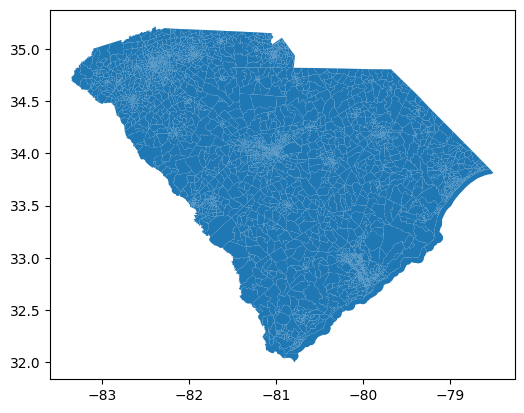

In [299]:
sc_block_inc_gdf.plot()
plt.show()

## Get precincts level geoDataFrames

In [300]:
sc_precinct_gdf = gpd.read_file('states/south_carolina/geodata/south_carolina_precincts.geojson')
print(len(sc_precinct_gdf.columns))

13


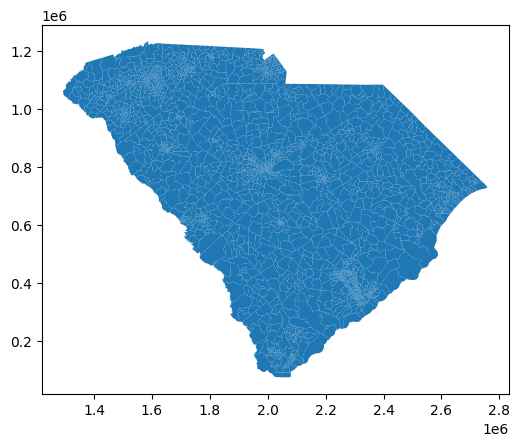

In [301]:

sc_precinct_gdf.plot()
plt.show()

In [302]:
print(sc_block_inc_gdf.columns)

Index(['GEOID', 'STATEFP', 'STATE', 'COUNTYFP', 'COUNTY', 'MEDN_INC22',
       'TOT_HOUS22', 'LESS_10K22', '10K_15K22', '15K_20K22', '20K_25K22',
       '25K_30K22', '30K_35K22', '35K_40K22', '40K_45K22', '45K_50K22',
       '50K_60K22', '60K_75K22', '75K_100K22', '100_125K22', '125_150K22',
       '150_200K22', '200K_MOR22', 'geometry'],
      dtype='object')


In [303]:
sc_block_geometry_gdf = sc_block_inc_gdf[['GEOID','STATEFP', 'STATE', 'COUNTYFP', 'COUNTY', 'geometry']]

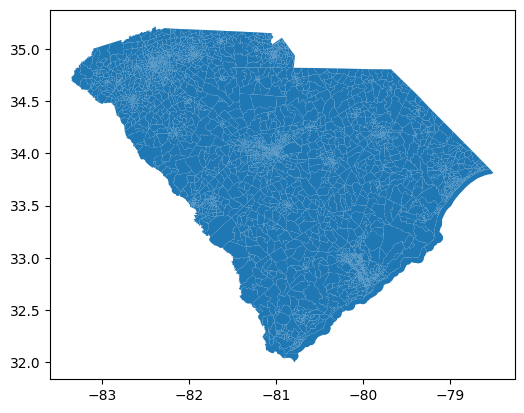

In [304]:
sc_block_geometry_gdf.plot()
plt.show()

## Merging geometry with economical data

In [305]:
print(sc_econ_df.columns)

Index(['GEOID', 'STATEFP', 'STATE', 'COUNTYFP', 'COUNTY', 'MEDN_INC22',
       'TOT_HOUS22', 'LESS_25K', '25K_45K', '45K_75K', '75K_125K', '125K_200K',
       '200K_MORE'],
      dtype='object')


In [306]:
sc_econ_df = sc_econ_df.drop(columns=['STATEFP', 'STATE', 'COUNTYFP', 'COUNTY'])

In [307]:
sc_block_geometry_gdf['GEOID'] = sc_block_geometry_gdf['GEOID'].astype(str)
sc_econ_df['GEOID'] = sc_econ_df['GEOID'].astype(str)

/Users/tonymac/miniconda3/envs/cse354/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [308]:
sc_block_geometry_gdf = sc_block_geometry_gdf.merge(sc_econ_df, on='GEOID')

In [309]:
print(sc_block_geometry_gdf.columns)

Index(['GEOID', 'STATEFP', 'STATE', 'COUNTYFP', 'COUNTY', 'geometry',
       'MEDN_INC22', 'TOT_HOUS22', 'LESS_25K', '25K_45K', '45K_75K',
       '75K_125K', '125K_200K', '200K_MORE'],
      dtype='object')


In [310]:
print(sc_race_df.columns)

Index(['GEOID', 'STATEFP', 'STATE', 'COUNTYFP', 'COUNTY', 'TOT_POP22',
       'NHSP_POP22', 'HSP_POP22', 'WHT_NHSP22', 'BLK_NHSP22', 'AIA_NHSP22',
       'ASN_NHSP22', 'HPI_NHSP22', 'OTH_NHSP22'],
      dtype='object')


In [311]:
sc_race_df = sc_race_df.drop(columns=['STATEFP', 'STATE', 'COUNTYFP', 'COUNTY'])

In [312]:
sc_block_geometry_gdf['GEOID'] = sc_block_geometry_gdf['GEOID'].astype(str)
sc_race_df['GEOID'] = sc_race_df['GEOID'].astype(str)
sc_block_geometry_gdf = sc_block_geometry_gdf.merge(sc_race_df, on='GEOID')

In [313]:
print(sc_block_geometry_gdf.columns)


Index(['GEOID', 'STATEFP', 'STATE', 'COUNTYFP', 'COUNTY', 'geometry',
       'MEDN_INC22', 'TOT_HOUS22', 'LESS_25K', '25K_45K', '45K_75K',
       '75K_125K', '125K_200K', '200K_MORE', 'TOT_POP22', 'NHSP_POP22',
       'HSP_POP22', 'WHT_NHSP22', 'BLK_NHSP22', 'AIA_NHSP22', 'ASN_NHSP22',
       'HPI_NHSP22', 'OTH_NHSP22'],
      dtype='object')


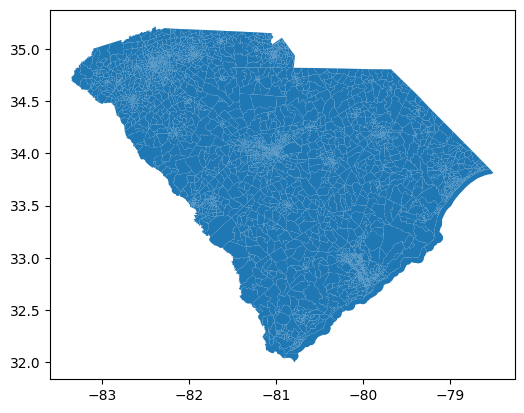

In [314]:
sc_block_geometry_gdf.plot()
plt.show()

In [315]:
# print(sc_election_df.columns)

In [316]:
# sc_block_geometry_gdf['GEOID'] = sc_block_geometry_gdf['GEOID'].astype(str)
# sc_election_df['GEOID'] = sc_election_df['GEOID'].astype(str)
# sc_block_geometry_gdf = sc_block_geometry_gdf.merge(sc_election_df, on='GEOID')

In [317]:
print(sc_block_geometry_gdf.columns)

Index(['GEOID', 'STATEFP', 'STATE', 'COUNTYFP', 'COUNTY', 'geometry',
       'MEDN_INC22', 'TOT_HOUS22', 'LESS_25K', '25K_45K', '45K_75K',
       '75K_125K', '125K_200K', '200K_MORE', 'TOT_POP22', 'NHSP_POP22',
       'HSP_POP22', 'WHT_NHSP22', 'BLK_NHSP22', 'AIA_NHSP22', 'ASN_NHSP22',
       'HPI_NHSP22', 'OTH_NHSP22'],
      dtype='object')


In [318]:
economic_gdf = sc_block_geometry_gdf[['GEOID', 'geometry'] + economic_columns].copy()
economic_gdf['category'] = 'economic'

race_gdf = sc_block_geometry_gdf[['GEOID', 'geometry'] + race_columns].copy()
race_gdf['category'] = 'race'

# election_gdf = sc_block_geometry_gdf [['GEOID'] + election_columns].copy()
# election_gdf['category'] = 'election'

In [319]:
final_sc_block_gdf = pd.concat([economic_gdf, race_gdf], ignore_index=True)

In [320]:
print(final_sc_block_gdf.columns)

Index(['GEOID', 'geometry', 'MEDN_INC22', 'TOT_HOUS22', 'LESS_25K', '25K_45K',
       '45K_75K', '75K_125K', '125K_200K', '200K_MORE', 'category',
       'TOT_POP22', 'NHSP_POP22', 'HSP_POP22', 'WHT_NHSP22', 'BLK_NHSP22',
       'AIA_NHSP22', 'ASN_NHSP22', 'HPI_NHSP22', 'OTH_NHSP22'],
      dtype='object')


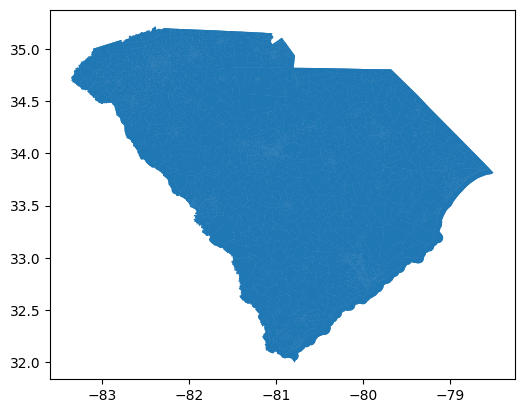

In [321]:
final_sc_block_gdf.plot()
plt.show()

In [322]:
print(len(final_sc_block_gdf))
print(final_sc_block_gdf.columns)

6816
Index(['GEOID', 'geometry', 'MEDN_INC22', 'TOT_HOUS22', 'LESS_25K', '25K_45K',
       '45K_75K', '75K_125K', '125K_200K', '200K_MORE', 'category',
       'TOT_POP22', 'NHSP_POP22', 'HSP_POP22', 'WHT_NHSP22', 'BLK_NHSP22',
       'AIA_NHSP22', 'ASN_NHSP22', 'HPI_NHSP22', 'OTH_NHSP22'],
      dtype='object')


In [323]:
final_sc_block_gdf.to_file('processed_combined/sc_block_combined.geojson', driver="GeoJSON")

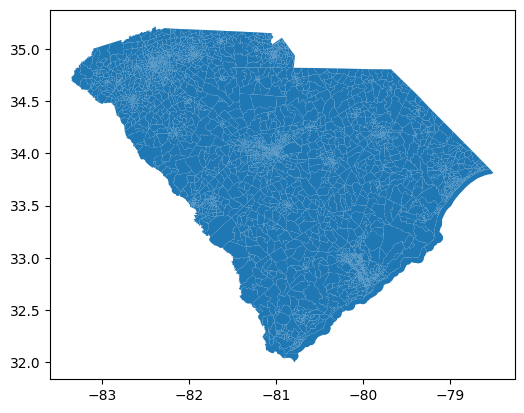

In [324]:
economic_gdf.plot()
plt.show()

In [325]:
precincts_gdf = gpd.read_file('states/south_carolina/geodata/south_carolina_precincts.geojson')

In [326]:
print(economic_gdf.columns)

Index(['GEOID', 'geometry', 'MEDN_INC22', 'TOT_HOUS22', 'LESS_25K', '25K_45K',
       '45K_75K', '75K_125K', '125K_200K', '200K_MORE', 'category'],
      dtype='object')


In [327]:
print(len(precincts_gdf))

2263


In [329]:
print(precincts_gdf.crs)

EPSG:2273


In [330]:
print(economic_gdf.crs)

EPSG:4269


In [331]:
if economic_gdf.crs != precincts_gdf.crs:
    economic_gdf = economic_gdf.to_crs(precincts_gdf.crs)

In [332]:
econ_blocks_with_precincts = gpd.sjoin(economic_gdf, precincts_gdf, how='left', predicate='within')

In [287]:
print(precincts_gdf.head())

  COUNTY PCODE  CODE_NAME  G20PRERTRU  G20PREDBID  G20PRELJOR  G20PREGHAW  \
0    013   110  Burton 1A         766         625          19           2   
1    013   111  Burton 1B         160         650           8           5   
2    013   113  Burton 2A         673         500          14           5   
3    013   114  Burton 2B         702         570          30           7   
4    013   115  Burton 2C         957         555          15           4   

   G20PREAFUE  G20USSRGRA  G20USSDHAR  G20USSCBLE  G20USSOWRI  \
0           1         747         647          13           1   
1           4         142         679           7           1   
2           0         649         520          24           1   
3           0         676         603          22           2   
4           2         948         565          21           0   

                                            geometry  
0  POLYGON ((2081535.382 215004.054, 2081567.367 ...  
1  POLYGON ((2080472.818 230194.779,

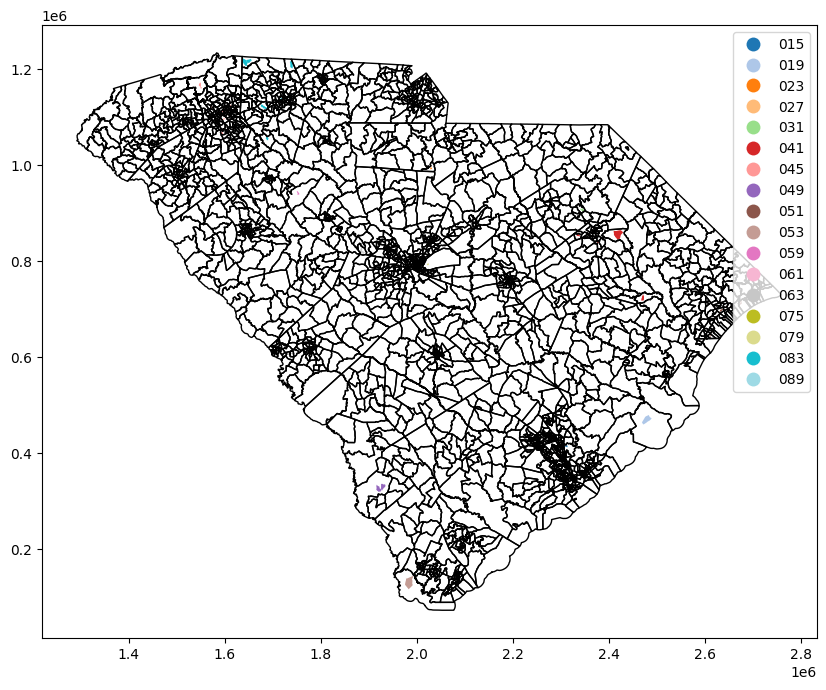

In [ ]:
econ_blocks_with_precincts.to_file('blocks_with_precincts.geojson', driver='GeoJSON')


In [335]:
econ_blocks_with_precincts.to_file("processed_combined/econ_blocks_with_precincts.geojson", driver="GeoJSON")